<a href="https://colab.research.google.com/github/saniaaa111/FMML_Project_and_Labs/blob/main/Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2024-05-22 11:00:11--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.06MB/s    in 0.3s    

2024-05-22 11:00:11 (3.06 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [9]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


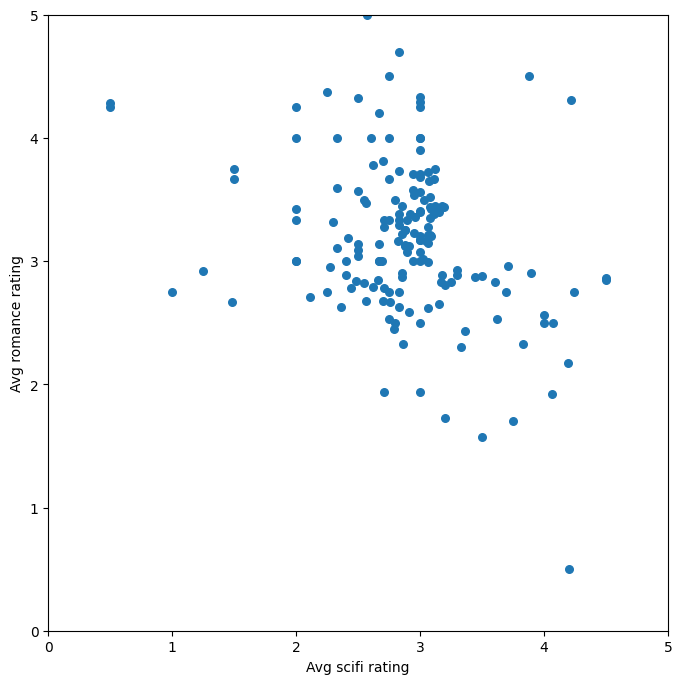

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


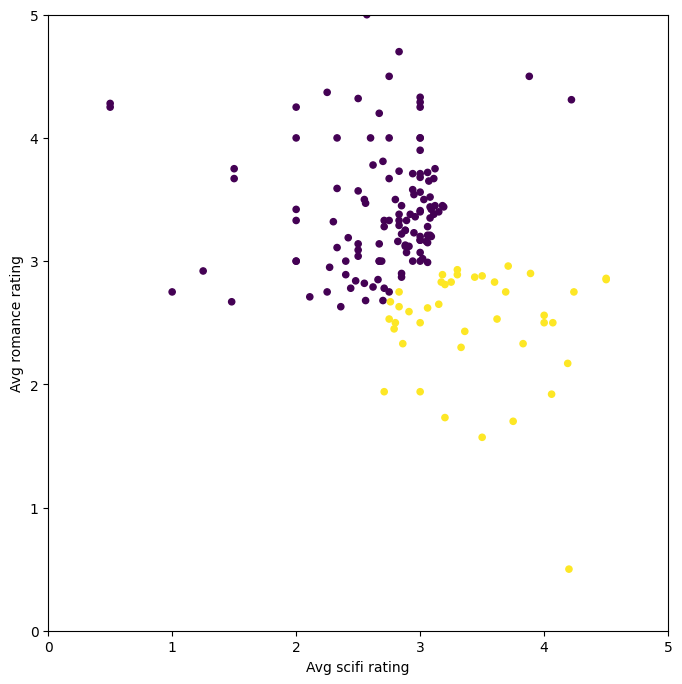

In [10]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


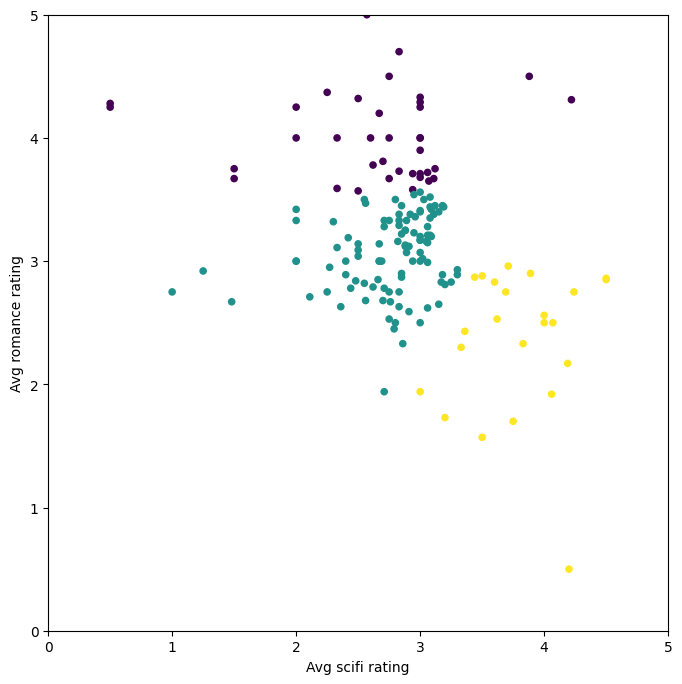

In [11]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

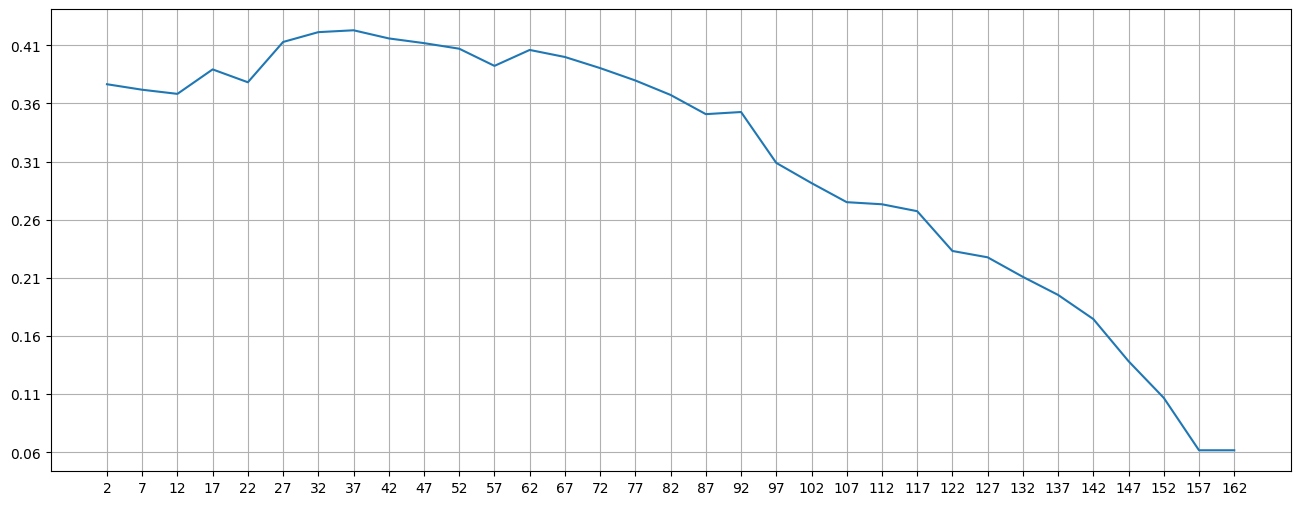

In [12]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


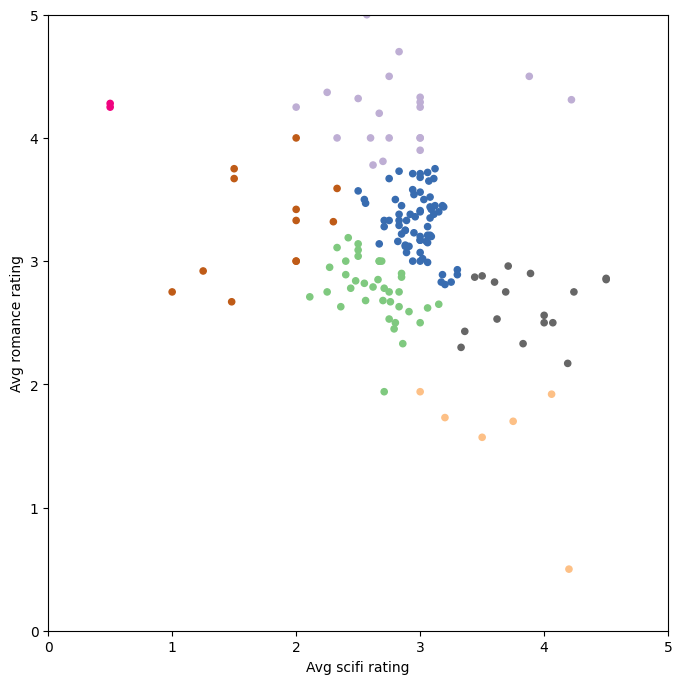

In [13]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [14]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


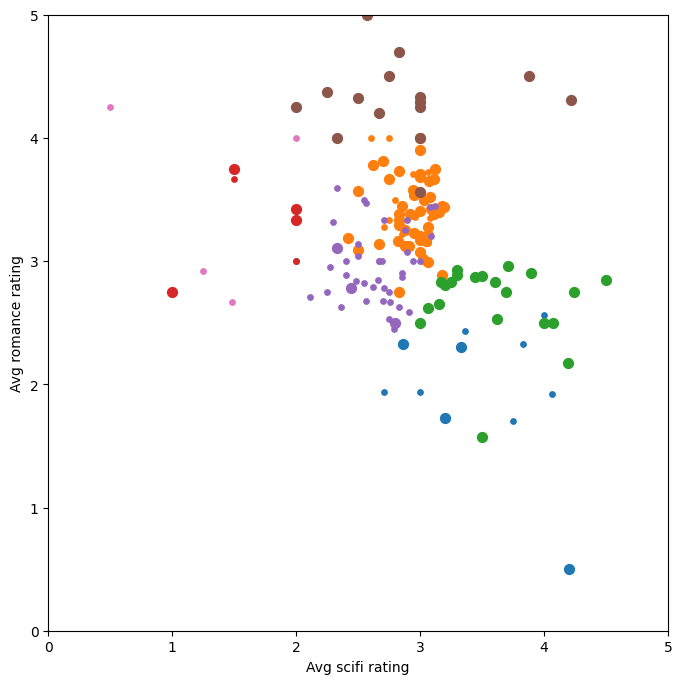

In [15]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

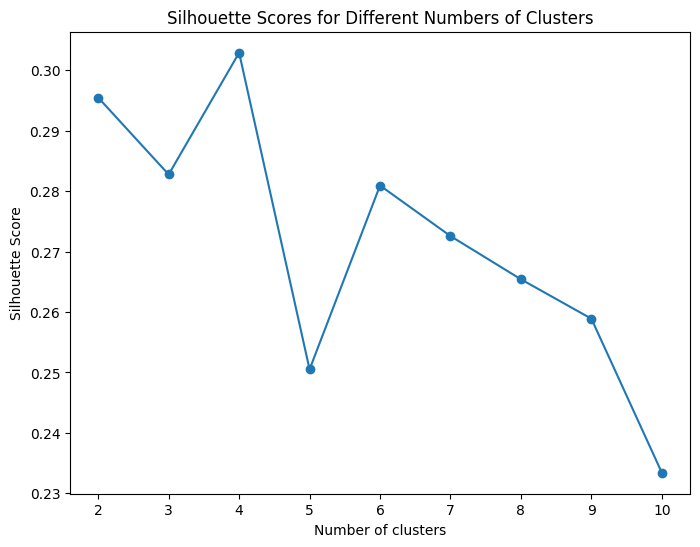

The optimal number of clusters is: 4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


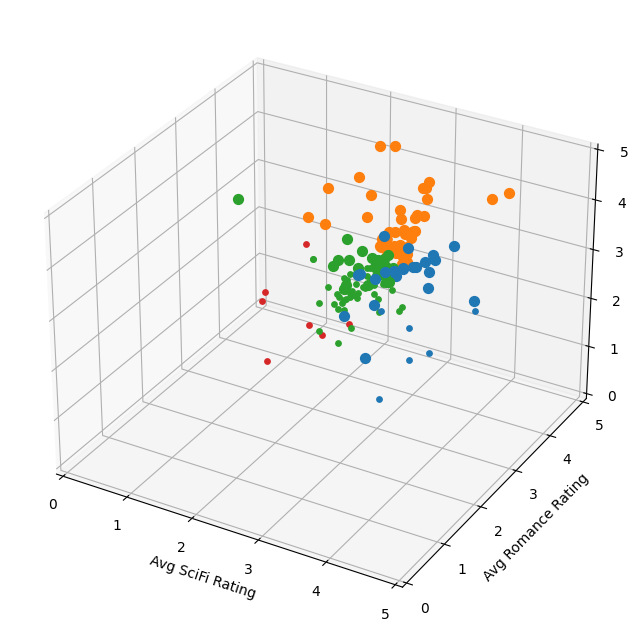

In [16]:
# CODE
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming biased_dataset_3_genres is a DataFrame containing the dataset
X_with_action = biased_dataset_3_genres[['avg_scifi_rating', 'avg_romance_rating', 'avg_action_rating']].values

# Define a function to draw clusters in 3D
def draw_clusters_3d(biased_dataset_3_genres, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_zlim(0, 5)
    ax.set_xlabel('Avg SciFi Rating')
    ax.set_ylabel('Avg Romance Rating')
    ax.set_zlabel('Avg Action Rating')

    clustered = pd.concat([biased_dataset_3_genres.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            ax.scatter(point['avg_scifi_rating'], point['avg_romance_rating'], point['avg_action_rating'],
                       s=size, color=color)

# Function to find the optimal number of clusters using silhouette score
def find_optimal_clusters(data, max_k):
    scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        predictions = kmeans.fit_predict(data)
        score = silhouette_score(data, predictions)
        scores.append((k, score))
    return scores

# Find the optimal number of clusters
max_k = 10
scores = find_optimal_clusters(X_with_action, max_k)

# Plot silhouette scores
plt.figure(figsize=(8,6))
plt.plot([k for k, s in scores], [s for k, s in scores], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.show()

# Determine the optimal number of clusters
optimal_k = max(scores, key=lambda item: item[1])[0]
print(f'The optimal number of clusters is: {optimal_k}')

# Cluster using the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k)
predictions_optimal = kmeans_optimal.fit_predict(X_with_action)

# Plot the clusters
draw_clusters_3d(biased_dataset_3_genres, predictions_optimal)


### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [19]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
import pandas as pd

# Define function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count the number of ratings for each movie
    rating_counts = user_movie_ratings.count()

    # 2- Sort the movies by the number of ratings in descending order
    sorted_movies = rating_counts.sort_values(ascending=False)

    # 3- Select the top `max_number_of_movies` movies
    most_rated_movies_columns = sorted_movies.index[:max_number_of_movies]
    most_rated_movies = user_movie_ratings[most_rated_movies_columns]

    return most_rated_movies

# Define function to get the users who rate the most movies
def get_users_who_rate_the_most(most_rated_movies, n_users):
    # Calculate the number of ratings per user
    most_rated_movies['num_ratings'] = -most_rated_movies.isnull().sum(axis=1)

    # Sort users by the number of ratings in descending order
    sorted_users = most_rated_movies.sort_values(by='num_ratings', ascending=False)

    # Select the top `n_users` users
    most_active_users = sorted_users.iloc[:n_users, :]

    # Drop the 'num_ratings' column as it is no longer needed
    most_active_users = most_active_users.drop('num_ratings', axis=1)

    return most_active_users

# Define the sorting by rating density function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_active_users = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_active_users

# Choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
print('Dataset dimensions: ', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())


Dataset dimensions:  (18, 30)
title   Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
userId                                                          
414                     5.0                               5.0   
590                     5.0                               4.5   
474                     3.0                               5.0   
480                     5.0                               5.0   
68                      3.5                               3.0   

title   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
userId                                                          
414                     5.0                               4.0   
590                     4.5                               3.5   
474                     4.0                               4.5   
480                     4.0                               4.5   
68                      2.0                               3.5   

title   Matrix, The (1999)  Star Wars: Episode IV - A New 

<ipython-input-21-2c11f6dc84d2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_rated_movies['num_ratings'] = -most_rated_movies.isnull().sum(axis=1)


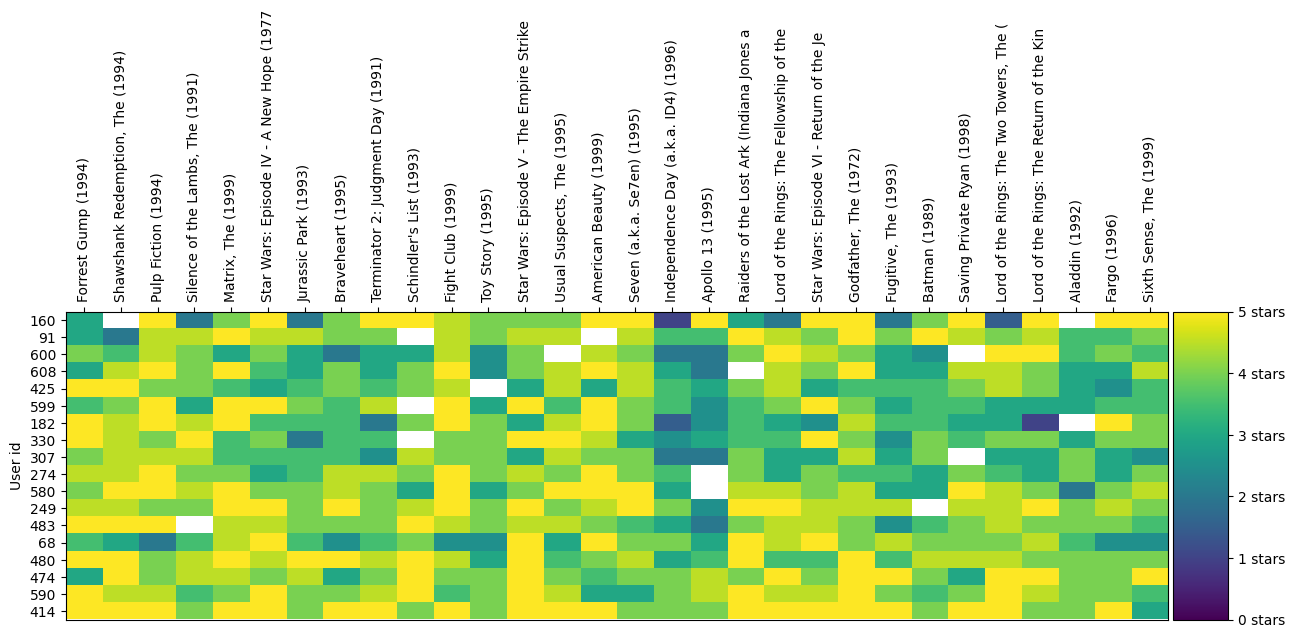

In [22]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [23]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [24]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

In [25]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)
# Select the mas number of users and movies heatmap cluster
# Cluster and print some of them
clustered = pd.concat([get_most_rated_movies(user_movie_ratings, 1000).reset_index(), pd.DataFrame({'group':predictions})], axis=1)
# draw_movie_clusters(clustered, max_users, max_movies)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


### Predictions and Recommendation

     userId  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
20       21                  4.5                               NaN   
51       52                  5.0                               5.0   
72       73                  NaN                               NaN   
110     111                  5.0                               4.5   
118     119                  4.0                               4.5   
140     141                  4.0                               4.0   
199     200                  4.0                               5.0   
211     212                  3.5                               4.5   
279     280                  4.0                               NaN   
291     292                  4.5                               5.0   
330     331                  NaN                               5.0   
364     365                  4.5                               4.5   
381     382                  4.5                               5.0   
465     466         

<ipython-input-21-2c11f6dc84d2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_rated_movies['num_ratings'] = -most_rated_movies.isnull().sum(axis=1)


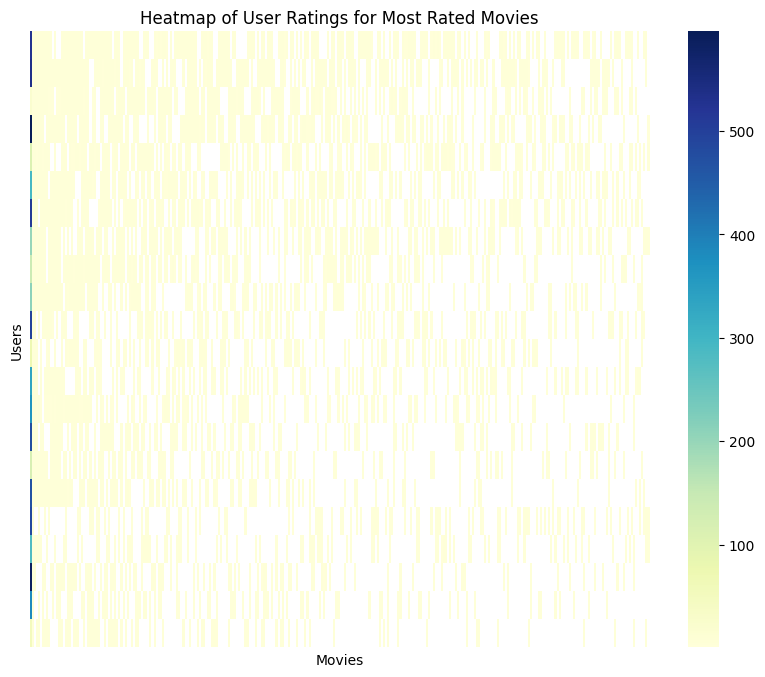

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming clustered DataFrame is available from previous steps
cluster_number = 1  # Ensure this is within the valid range of cluster IDs

# Let's filter to only see the region of the dataset with the most number of values
n_users = 75
n_movies = 300

# Check if the cluster number is valid
if cluster_number not in clustered.group.unique():
    raise ValueError(f"Cluster number {cluster_number} is not valid. Available clusters: {clustered.group.unique()}")

# Filter the dataset for the specified cluster
cluster = clustered[clustered.group == cluster_number].drop(['group'], axis=1)

# Print the filtered cluster
print(cluster)

# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)

# Define the function to draw the heatmap
def draw_movies_heatmap(data, axis_labels=True):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data, cmap='YlGnBu', cbar=True, xticklabels=axis_labels, yticklabels=axis_labels)
    plt.xlabel('Movies')
    plt.ylabel('Users')
    plt.title('Heatmap of User Ratings for Most Rated Movies')
    plt.show()

# Draw the heatmap
draw_movies_heatmap(cluster, axis_labels=False)


In [28]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

4.0

In [29]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

userId                                                           329.500000
Dark Knight, The (2008)                                            4.090909
Pirates of the Caribbean: The Curse of the Black Pearl (2003)      3.815789
Incredibles, The (2004)                                            3.583333
Forrest Gump (1994)                                                4.323529
Shrek (2001)                                                       3.588235
Matrix, The (1999)                                                 4.000000
Ratatouille (2007)                                                 3.852941
Inception (2010)                                                   3.852941
Kill Bill: Vol. 1 (2003)                                           3.812500
Gladiator (2000)                                                   3.843750
Lord of the Rings: The Fellowship of the Ring, The (2001)          3.843750
Finding Nemo (2003)                                                3.875000
Lord of the 

In [30]:
cluster

,userId,"Dark Knight, The (2008)",Pirates of the Caribbean: The Curse of the Black Pearl (2003),"Incredibles, The (2004)",Forrest Gump (1994),Shrek (2001),"Matrix, The (1999)",Ratatouille (2007),Inception (2010),Kill Bill: Vol. 1 (2003),...,Pretty Woman (1990),Pocahontas (1995),"Patriot, The (2000)",Ocean's Thirteen (2007),Monty Python and the Holy Grail (1975),Saw (2004),"Big Lebowski, The (1998)",Coyote Ugly (2000),There's Something About Mary (1998),She's All That (1999)
524,525,4.0,4.5,3.5,4.0,3.5,4.0,3.5,4.0,4.5,...,4.0,3.0,NaN,NaN,4.5,NaN,NaN,3.0,3.0,NaN
533,534,2.0,4.5,4.0,4.5,4.5,4.0,4.0,4.5,4.5,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN
20,21,3.5,4.0,3.5,4.5,4.0,4.0,3.5,3.5,1.5,...,4.0,3.0,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN
595,596,4.0,3.0,4.0,3.5,4.0,4.0,NaN,4.0,3.5,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,2.5
110,111,4.0,3.0,1.0,5.0,3.0,0.5,3.0,4.5,3.5,...,4.0,3.5,NaN,3.5,NaN,0.5,NaN,3.0,NaN,4.0
291,292,4.0,4.0,3.5,4.5,4.0,4.0,4.0,3.0,NaN,...,3.5,NaN,NaN,NaN,4.0,2.0,NaN,NaN,NaN,NaN
508,509,3.5,3.5,4.0,NaN,4.0,3.5,3.5,3.5,3.0,...,NaN,3.5,NaN,3.0,4.0,NaN,3.5,NaN,NaN,NaN
199,200,5.0,4.0,4.0,4.0,3.0,5.0,4.5,NaN,5.0,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,3.5,4.0,4.0
140,141,5.0,4.0,4.5,4.0,4.0,3.5,3.0,NaN,3.0,...,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN
211,212,3.5,3.5,3.0,3.5,4.0,3.0,3.0,3.5,3.5,...,NaN,NaN,NaN,NaN,4.0,2.5,3.0,NaN,NaN,NaN


In [33]:
# Print the available user IDs in the cluster DataFrame
print("Available user IDs:", cluster.index)

# Pick a valid user ID from the dataset
# Ensure this user ID exists in the printed list above
valid_user_id = cluster.index[0]  # Selecting the first user ID for demonstration

# Verify if the user ID exists in the DataFrame
if valid_user_id not in cluster.index:
    raise KeyError(f"User ID {valid_user_id} not found in the dataset.")

# Get all this user's ratings
user_2_ratings = cluster.loc[valid_user_id, :]

# Which movies did they not rate?
user_2_unrated_movies = user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = cluster.mean().loc[user_2_unrated_movies.index]

# Let's sort by rating so the highest rated movies are presented first
top_avg_ratings = avg_ratings.sort_values(ascending=False)[:20]

# Print the top 20 movie recommendations
print("Top 20 movie recommendations for user", valid_user_id)
print(top_avg_ratings)


Available user IDs: Index([524, 533,  20, 595, 110, 291, 508, 199, 140, 211, 494,  72, 330, 364,
       474, 118, 465, 483, 279, 585, 381,  51],
      dtype='int64')
Top 20 movie recommendations for user 524
Back to the Future Part II (1989)                        4.583333
Hot Fuzz (2007)                                          4.500000
Departed, The (2006)                                     4.357143
Rogue One: A Star Wars Story (2016)                      4.333333
Fast and the Furious, The (2001)                         4.250000
Inglourious Basterds (2009)                              4.222222
Tropic Thunder (2008)                                    4.214286
Slumdog Millionaire (2008)                               4.150000
Wolf of Wall Street, The (2013)                          4.142857
X2: X-Men United (2003)                                  4.142857
Good Will Hunting (1997)                                 4.136364
Sherlock Holmes: A Game of Shadows (2011)                4.125000


## Using Collaborative Filtering (With fast.ai)

In [34]:
! [ -e /content ] && pip install -Uqq fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.5 MB/s eta 0:00:00


In [35]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [36]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [37]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [38]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [39]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [40]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [41]:
dls.show_batch()

,user,title,rating
0,224,Fried Green Tomatoes (1991),4
1,87,Supercop (1992),3
2,385,East of Eden (1955),2
3,899,"Right Stuff, The (1983)",3
4,416,Tales from the Hood (1995),4
5,13,Bogus (1996),4
6,305,Sling Blade (1996),4
7,521,Ben-Hur (1959),3
8,429,Taxi Driver (1976),4
9,503,Ulee's Gold (1997),5


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [42]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [43]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.873766,0.951219,00:09
1,0.690700,0.901006,00:08
2,0.515976,0.877757,00:08
3,0.472951,0.864184,00:08
4,0.437905,0.858405,00:08


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [44]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [45]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [46]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [47]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3405),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2748), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2640), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2521),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2478), 'Anaconda (1997)', 2.289473684210526),
 (tensor(-0.2474), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2422), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2333), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2329), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2324), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2285), 'Playing God (1997)', 2.627906976744186),
 (tensor(-0.2208), 'Lawnmower Man, The (1992)', 2.4461538461538463),
 (tensor(-0.2204), 'Booty Call (1997)', 2.1666666666666665),
 (tensor(-0.2184), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2153), 'Jaws 2 (1978)', 2.6666666666666665)

Or the ones with the best bias:

In [48]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6102), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5754), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5750), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5679), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5624), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5255), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4890), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4842), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4811), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4700), '12 Angry Men (1957)', 4.344),
 (tensor(0.4579), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4359), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4313), 'Secrets & Lies (1996)', 4.265432098765432),
 (tensor(0.4263), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4212), 'To Kill a Mockingbird (1962)', 4.292237442922374)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [49]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [50]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [51]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1007), 'When We Were Kings (1996)'),
 (tensor(1.0352), 'Manchurian Candidate, The (1962)'),
 (tensor(1.0293), 'Fargo (1996)'),
 (tensor(1.0274), 'Close Shave, A (1995)'),
 (tensor(1.0243), 'Casablanca (1942)'),
 (tensor(1.0124), 'Third Man, The (1949)'),
 (tensor(1.0007),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(1.0004), 'Lawrence of Arabia (1962)'),
 (tensor(0.9851), 'Godfather, The (1972)'),
 (tensor(0.9642), 'Wallace & Gromit: The Best of Aardman Animation (1996)')]

And the worst:

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2129), 'Home Alone 3 (1997)'),
 (tensor(-1.1717), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1036), 'Jungle2Jungle (1997)'),
 (tensor(-1.0810), "McHale's Navy (1997)"),
 (tensor(-1.0619), 'Striptease (1996)'),
 (tensor(-1.0520), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0479), 'Stupids, The (1996)'),
 (tensor(-1.0265), 'Beautician and the Beast, The (1997)'),
 (tensor(-1.0191), 'Congo (1995)'),
 (tensor(-1.0096), 'Mortal Kombat: Annihilation (1997)')]

Same thing for our second dimension:

In [54]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [55]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9080), 'Kansas City (1996)'),
 (tensor(0.8541), 'Trainspotting (1996)'),
 (tensor(0.8505), 'Crumb (1994)'),
 (tensor(0.8004), 'Barb Wire (1996)'),
 (tensor(0.7788), 'Cable Guy, The (1996)'),
 (tensor(0.7172), 'Serial Mom (1994)'),
 (tensor(0.7044), 'Raging Bull (1980)'),
 (tensor(0.7012), 'Three Colors: Blue (1993)'),
 (tensor(0.6954), 'To Die For (1995)'),
 (tensor(0.6939), 'Lost Highway (1997)')]

In [56]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1161), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9851), 'Braveheart (1995)'),
 (tensor(-0.9835), 'Titanic (1997)'),
 (tensor(-0.8669), 'Air Force One (1997)'),
 (tensor(-0.8639), 'Empire Strikes Back, The (1980)'),
 (tensor(-0.8383), 'Back to the Future (1985)'),
 (tensor(-0.8361), 'Lion King, The (1994)'),
 (tensor(-0.8318), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8069), "It's a Wonderful Life (1946)"),
 (tensor(-0.7942), 'Miracle on 34th Street (1994)')]

And we can even plot the movies according to their scores on those dimensions:

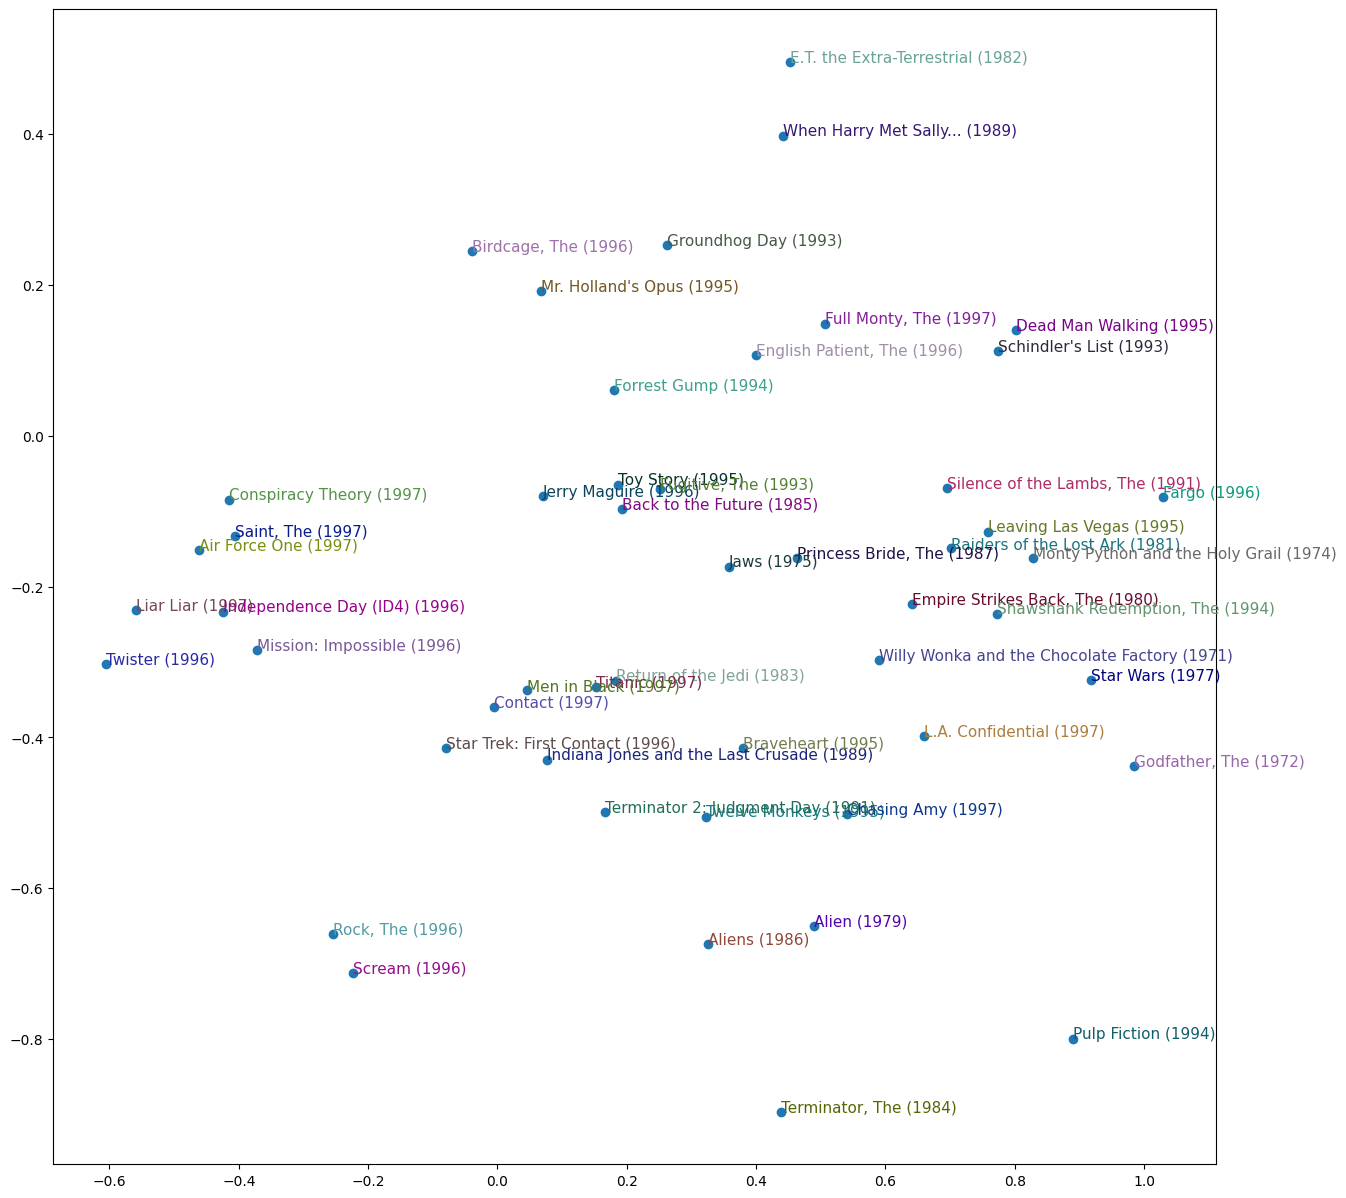

In [57]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [61]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357234 sha256=cad3c73902f2b27201c7c5d49132be516115037368c8566cadfc13df317ec5cc
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


Dataset ml-100k could not be found. Do you want to download it? [Y/n] yes
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


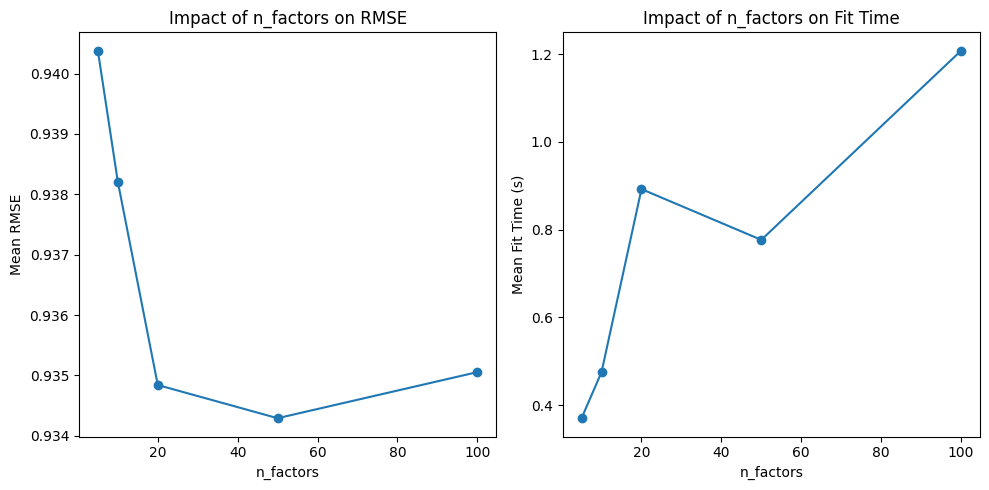

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

# Define a function to conduct experiments with different n_factors values
def conduct_experiments(n_factors_list, other_parameters={}):
    results = {'n_factors': [], 'mean_rmse': [], 'mean_fit_time': []}
    for n_factors in n_factors_list:
        # Update the parameters dictionary with the current n_factors value
        parameters = {'n_factors': n_factors, **other_parameters}

        # Create a surprise Reader and Dataset
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_builtin('ml-100k', reader)

        # Initialize the SVD algorithm with the specified parameters
        algo = SVD(**parameters)

        # Perform cross-validation
        cv_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)

        # Store the results
        results['n_factors'].append(n_factors)
        results['mean_rmse'].append(np.mean(cv_results['test_rmse']))
        results['mean_fit_time'].append(np.mean(cv_results['fit_time']))

    return results

# Define a range of n_factors values to test
n_factors_list = [5, 10, 20, 50, 100]

# Conduct experiments with different n_factors values
results = conduct_experiments(n_factors_list)

# Plot the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(results['n_factors'], results['mean_rmse'], marker='o')
plt.title('Impact of n_factors on RMSE')
plt.xlabel('n_factors')
plt.ylabel('Mean RMSE')

plt.subplot(1, 2, 2)
plt.plot(results['n_factors'], results['mean_fit_time'], marker='o')
plt.title('Impact of n_factors on Fit Time')
plt.xlabel('n_factors')
plt.ylabel('Mean Fit Time (s)')

plt.tight_layout()
plt.show()
